# Fashion-MNIST を使ったClassification

fashion-MNIST データセットを使って画像をclassificationを行います

## dataset の確認

今回はオープンデータのfashion-MNISTを使うので、中身を確認します

データの大元はここにあります。
https://github.com/zalandoresearch/fashion-mnist

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = fashion_mnist.load_data()

## それぞれのデータ形を表示してみましょう
print("train feature shape", X_train_orig.shape)
print("train label shape", y_train_orig.shape)
print("test feature shape", X_test_orig.shape)
print("test label shape", y_test_orig.shape)

train feature shape (60000, 28, 28)
train label shape (60000,)
test feature shape (10000, 28, 28)
test label shape (10000,)


訓練データは60,000件、テストデータは10,000件で、画像のshapeは(28, 28)であることがわかります。縦横しかないからカラー情報しかもたないグレースケール画像であることがわかります。

featureとなる画像データを見てみると様々なファッションアイテムの画像が入っています。

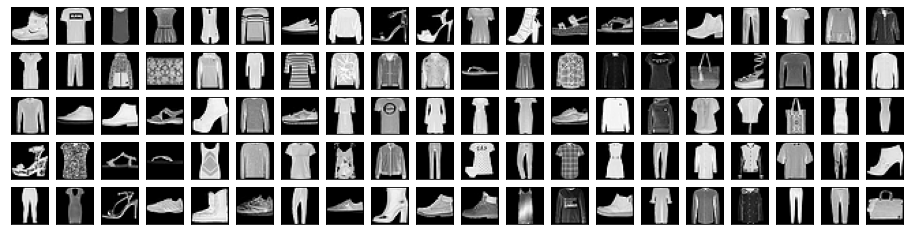

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def show(n_cols, n_rows, train_orig):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16,4))
    for ax, pixels in zip(axs.flat, train_orig):
        ax.imshow(pixels, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

show(20, 5, X_train_orig)

labelの意味は https://github.com/zalandoresearch/fashion-mnist#labels ここにあります。

データのそれぞれのカテゴリごとに6,000件ずつ、均等にはいっているようです

<BarContainer object of 10 artists>

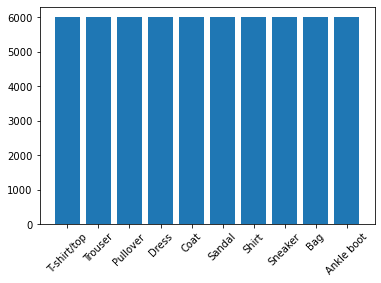

In [3]:
import numpy as np

labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]
left = range(0, 10)
height = np.zeros(10)
for v in y_train_orig:
    height[v] += 1
    
plt.xticks(rotation=45)
plt.bar(left, height, tick_label=labels, align="center")

これでデータについてはわかったので、モデルを作成していきます。

## data preprocessing

モデルを作成するにあたって、データの前処理を行います。
ここでは3つの処理を行っています。
- kerasのcnnで使用するメソッドであるConv2Dは入力のshapeとして(batch_size, rows, cols, channels)を取るため、データをexpandします。
- データの正規化を行います。 (値の範囲を[0-255]から[0-1]にします。)
- ラベルをone hot表現に変換します。('Trouser'が正解の場合、[0,1,0,0,0,0,0,0,0,0]になります。)

In [4]:
## shapeを(batch_size, rows, cols, channels)にexpandする。 (batch_sizeはtrainning時に指定するため、現時点では全データ数で大丈夫です。)
X_train = np.expand_dims(X_train_orig, -1)
X_test = np.expand_dims(X_test_orig, -1)

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

## グレースケールの 0-255 の値を 正規化して 0-1 の浮動小数にする
X_train = X_train / 255.0
X_test = X_test / 255.0

## one hot vectorにする
y_train = tf.keras.utils.to_categorical(y_train_orig, 10)
y_test = tf.keras.utils.to_categorical(y_test_orig, 10)

print("one hot label shape", y_train.shape)

X_train shape (60000, 28, 28, 1)
X_test shape (10000, 28, 28, 1)
one hot label shape (60000, 10)


## model

kerasでmodelを作成する場合には2つの方法があります。 Sequential API を使う方法と、Funcional API を使う方法です。

Sequential APIはシンプルで単純な構造のmodelを作る際に便利で、Functional APIは複数の入力やアウトプットをもったり、内部で分岐処理があるような複雑なモデルを作成する際に向いています。
今回はSequential APIを用いてmodelを作ってみましょう

https://www.tensorflow.org/api_docs/python/tf/keras/layers ここからcnnを使ってもmodelを組んでみましょう

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

def cnn():
    model = tf.keras.Sequential()
    model.add(Conv2D(32, kernel_size = (3,3), activation = "relu"))
    model.add(Conv2D(64, kernel_size = (3,3), activation = "relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size = (3,3), activation = "relu"))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    return model

## training: 訓練

まずモデルを組み立てて、中身を見てみましょう

In [6]:
%rm -rf ./logs

model = cnn()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1688/1688 [==============================] - 8s 5ms/step - loss: 0.4891 - categorical_accuracy: 0.8248 - val_loss: 0.2954 - val_categorical_accuracy: 0.8902
Epoch 2/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3140 - categorical_accuracy: 0.8875 - val_loss: 0.2461 - val_categorical_accuracy: 0.9093
Epoch 3/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2672 - categorical_accuracy: 0.9042 - val_loss: 0.2280 - val_categorical_accuracy: 0.9160
Epoc

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  36928     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8

## test: 検証

訓練が終わったので、訓練データには存在しないデータで検証をしていきます

In [8]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2203 - categorical_accuracy: 0.9251


[0.22026164829730988, 0.9251000285148621]

表示されている情報は lossとcategorical_accuracyです。訓練の結果とどの程度違いがあったでしょうか？ overfitはしていないでしょうか？

## prediction: 推論

では出来上がったmodelにリクエストを投げて実際に処理を行ってみましょう

0 Coat 99.85395669937134%
1 Sandal 99.99200105667114%
2 Sandal 94.18050646781921%
3 Dress 99.99971389770508%
4 Coat 95.66537737846375%
5 Trouser 100.0%
6 Pullover 96.09728455543518%
7 Coat 59.649598598480225%
8 Bag 99.99967813491821%
9 T-shirt/top 99.67542290687561%


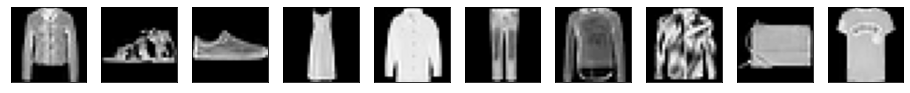

In [9]:
predictions = model.predict(X_test[10:20])
for i, p in enumerate(predictions):
    print(i, labels[np.argmax(p)], "{}%".format(p[np.argmax(p)]*100))
show(10, 1, X_test_orig[10:20])

## 保存

出来上がったモデルは現時点では、notebookのメモリ上にしかありません。これを保存します。  
save_formatはtensorflow2.0以降のデフォルトの保存形式になっているsaved_model形式で保存を行うための指定です。

In [11]:
USER    = "kojo"
BUCKET  = "mixi-ml-handson-2020"
VERSION = "001"

model.save("gs://{}/{}/{}".format(BUCKET, USER, VERSION), save_format="tf")

INFO:tensorflow:Assets written to: gs://mixi-ml-handson-2020/username/001/assets


# 追加課題

＋ modelの構成を変更して、どのくらい性能が変わるか確認してみよう
  + Dropoutの有無、正規化の有無、CNNからDNNにした場合
+ 今回はdataを全てメモリ常に展開しているが、実際の画像データセットはメモリ上で処理できないことが多い。そのためにdataset libraryを使ってみよう

# Appendix:

## tensorboard

以下のtensorboardでの結果のは docker上で起動していることを想定しています。

In [5]:
%reload_ext tensorboard
%tensorboard --logdir ./logs --host 0.0.0.0 --port 6006